In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, Attention
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import LeakyReLU

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)

from sklearn.model_selection import train_test_split

import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]
from joblib import Parallel, delayed

## Reading and preparing data

In [2]:
df = pd.read_csv("../data/processed/train.csv") 
df.head(n=5)  # visualize the data.

,Unnamed: 0,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0,1.0,1,0.25171,3672.4,4466.3,9.5122,27.057,42.473,...,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,1,0,1.0,2,0.25234,3642.2,4568.7,9.4145,26.999,42.586,...,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,2,0,1.0,3,0.24840,3643.1,4507.5,9.2901,26.927,42.278,...,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,3,0,1.0,4,0.25153,3628.3,4519.3,9.3347,26.999,42.330,...,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,4,0,1.0,5,0.21763,3655.8,4571.0,9.3087,26.901,42.402,...,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681


In [3]:
# Remove simulation columns
df = df.drop(['simulationRun', 'sample', 'Unnamed: 0'], axis=1)
#ignore the hard to detect faults
df = df.drop(df[(df.faultNumber == 3) | (df.faultNumber == 9) | (df.faultNumber == 15)].index).reset_index()
#make label binary
df.loc[df['faultNumber'] > 0, 'faultNumber'] = 1


In [4]:
#balance classes
df = df[df['faultNumber']!=0].sample(n=len(df[df['faultNumber']==0])).append(df[df['faultNumber']==0])
df

,index,faultNumber,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
1775941,2004421,1,0.67782,3598.3,4433.6,8.4818,27.025,41.472,2703.4,76.963,...,52.862,66.524,55.708,18.901,23.442,43.325,47.673,34.174,39.221,20.641
5483361,6366561,1,0.28924,3657.7,4361.6,9.8264,27.128,42.575,2675.8,71.933,...,52.338,28.952,65.931,21.808,40.045,42.415,48.800,30.116,39.409,15.966
6594337,7673377,1,0.28443,3614.5,4526.2,9.2829,26.934,42.143,2700.5,74.604,...,54.184,27.936,60.924,21.409,39.476,38.000,46.045,45.477,41.313,18.931
4578773,5302613,1,0.23573,3627.2,4479.8,9.3398,26.952,42.309,2704.5,75.166,...,53.781,23.806,61.833,22.301,38.591,40.994,47.316,50.161,44.732,18.260
2866242,3287682,1,0.25882,3675.1,4501.0,9.3489,26.960,42.499,2701.8,74.750,...,53.800,25.777,61.220,22.149,41.274,37.047,48.394,51.199,40.898,19.910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,479995,0,0.26428,3671.5,4510.8,9.2852,27.141,42.297,2699.9,74.296,...,53.942,26.022,61.709,22.417,40.510,36.731,50.115,52.721,40.927,18.854
479996,479996,0,0.25132,3573.4,4483.9,9.2872,26.604,42.311,2698.1,74.629,...,53.760,24.585,61.267,21.928,39.893,34.136,47.714,52.908,41.412,18.847
479997,479997,0,0.25105,3622.6,4433.3,9.3998,26.707,41.936,2699.5,75.484,...,54.366,24.613,61.745,22.212,40.098,35.585,48.241,53.099,40.150,16.791
479998,479998,0,0.24521,3660.5,4485.2,9.3885,26.936,42.639,2700.5,74.614,...,53.289,24.371,62.811,22.249,39.536,35.609,46.495,53.157,41.065,17.097


# Prepare data for LSTM models

In [5]:
input_X = df.loc[:, df.columns != 'faultNumber'].values  # converts the df to a numpy array
input_y = df['faultNumber'].values

n_features = input_X.shape[1]  # number of features




In [6]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [7]:
lookback = 5  # Equivalent to 15 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

### Divide the data into train, valid, and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_test, y_test, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [9]:
X_train.shape

(153599, 5, 1, 53)

In [10]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train!=0] #any fault

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid!=0] #any fault

In [11]:
print(X_valid_y0.shape)
print(X_valid_y1.shape)

(19087, 5, 1, 53)
(19313, 5, 1, 53)


#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [12]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

### Standardize the data

In [13]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [14]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [15]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [16]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

## LSTM Autoencoder training

Initialize v1 of the autoencoder architecture. More experimentation possible

In [17]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 52

epochs = 40
batch = 256
lr = 0.002
num_inducing_points = n_features

Define the trainable prior and posterior distributions to estimate uncertainties

In [19]:
input_shape=(timesteps, n_features)
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(timesteps), scale=1),
                        reinterpreted_batch_ndims=1)
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(128, input_shape=input_shape, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(64, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(32, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(16, return_sequences=False))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
#helper layer to get the right shape for tfp layer
lstm_autoencoder.add(Dense(tfpl.MultivariateNormalTriL.params_size(timesteps),
                       activation=None))
lstm_autoencoder.add(tfpl.MultivariateNormalTriL(
                        timesteps,
                        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)))

lstm_autoencoder.add(RepeatVector(timesteps))

# Decoder
lstm_autoencoder.add(LSTM(16, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(32, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(64, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(128, return_sequences=True))
lstm_autoencoder.add(LeakyReLU(alpha=0.05))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
# bring the output into a time distributed shape
#lstm_autoencoder.add(tfpl.DenseVariational(n_features, posterior_mean_field, prior_trainable)) 
# mathematically like a Dense Layer but with distributions 

#helper layer to get the right shape for tfp layer
lstm_autoencoder.add(Dense(tfpl.IndependentNormal.params_size(n_features),
                       activation=None))
lstm_autoencoder.add(tfpl.IndependentNormal(n_features))
# returns n_features independent normal distributions.
# note: an Autoencoder tries to "recreate" the input

#lstm_autoencoder.summary()

In [20]:
adam = optimizers.Adam(lr)

#neg loglikelihood for well defined covariance matrices
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
lstm_autoencoder.compile(loss=negative_log_likelihood, optimizer=adam)

cp = ModelCheckpoint(filepath="variational_autoencoder_dropout2.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=1).history

Epoch 1/40
301/301 [==============================] - 51s 116ms/step - loss: 77.1496 - val_loss: 75.2072
Epoch 2/40
301/301 [==============================] - 32s 106ms/step - loss: 75.2621 - val_loss: 75.2109
Epoch 3/40
301/301 [==============================] - 31s 104ms/step - loss: 75.1995 - val_loss: 75.2063
Epoch 4/40
301/301 [==============================] - 31s 105ms/step - loss: 75.2290 - val_loss: 75.2016
Epoch 5/40
301/301 [==============================] - 31s 104ms/step - loss: 75.1945 - val_loss: 75.1966
Epoch 6/40
301/301 [==============================] - 31s 104ms/step - loss: 75.2322 - val_loss: 75.1934
Epoch 7/40
301/301 [==============================] - 31s 104ms/step - loss: 75.2453 - val_loss: 75.1963
Epoch 8/40
301/301 [==============================] - 31s 104ms/step - loss: 75.2008 - val_loss: 75.1925
Epoch 9/40
301/301 [==============================] - 31s 104ms/step - loss: 75.2071 - val_loss: 75.1950
Epoch 10/40
301/301 [==============================] - 

$\text{ELBO}(x)=\int \space \text{d}z \space q(z|x) \space \text{log}p(x|z) \space + \space \int \space \text{d}z \space q(z|x) \frac{q(z|x)}{p(z)}$

$p(z)$, the prior on the latent representation z,

$q(z|x)$, the variational encoder

$p(x|z)$, the decoder — how likely is the image x given the latent representation z.

The first integral in the ELBO equation is the reconstruction term. It asks how likely we are to start at an image x, encode it to z, decode it, and get back the original x

In [21]:
#lstm_autoencoder.save('../models/LSTM_Variational_Autoencoder_dropout2')

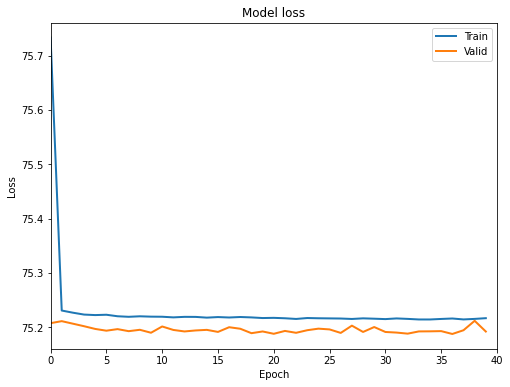

In [22]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
#plt.ylim(2.5,4)
plt.xlim(0,40)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

why does the loss keep going down? higher training rate? just the nature of loglikelihood?

In [ ]:
#lstm_autoencoder = tf.keras.models.load_model(
#    '../models/LSTM_Autoencoder_prob_128', custom_objects=None, compile=True
#)

## Predictions using the Autoencoder
    - test for all faults
    - test for performance on individual faults "only fault n"
    - different cuts for different faults?

Draw n-times for the validation data set

every forward pass draws from the final distribution

this is computationally expensive but we get a posterior distribution to evaluate

in production there would be a smaller window used so computation time is significantly lower

In [23]:
n_vals = 10
yhats = [lstm_autoencoder.predict(X_valid_scaled) for _ in range(n_vals)]

use the predictions like an ensemble

In [24]:
#average over all predictions 
avg = np.squeeze(yhats).mean(axis=0)
std = np.squeeze(yhats).std(axis=0)
print(np.shape(avg))

#calculate some regression metrics
mse = np.mean(np.power(flatten(X_valid_scaled)-flatten(avg),2),axis=1)
print(mse)
chi2 = np.sum(np.power(flatten(X_valid_scaled)-flatten(avg),2)/flatten(std), axis=1)
print(chi2)
wmse = np.mean(np.power((flatten(X_valid_scaled)-flatten(avg))/flatten(std),2),axis=1)
print(wmse)
avgstd = np.mean(flatten(std),axis=1)
print(avgstd)

anomaly = np.mean(np.power((flatten(X_valid_scaled)-flatten(avg)),2)*flatten(std),axis=1)
print(anomaly)

y_valid[y_valid!=0] = 1
error_df = pd.DataFrame({'MSE': mse,
                         'Weighted MSE': wmse,
                         'Chi2': chi2,
                         'AVGSTD': avgstd, 
                         'anomaly' : anomaly,
                         'True_class': y_valid.tolist()})

error_df.to_csv('error_df.csv')

(38400, 5, 53)
[ 1.6351159   0.73208681  1.01117021 ... 15.51233661  1.71381804
  0.78277231]
[ 96.6215157   45.83687406  59.83514108 ... 819.06627735 118.73438135
  46.41451471]
[ 2.10096891  1.0865164   1.29365526 ... 16.07143401  3.17617689
  1.02253702]
[0.90400572 0.90247518 0.92125226 ... 0.94981034 0.88174048 0.93958855]
[ 1.51347702  0.65479365  0.92804903 ... 16.21681294  1.40614643
  0.73119286]


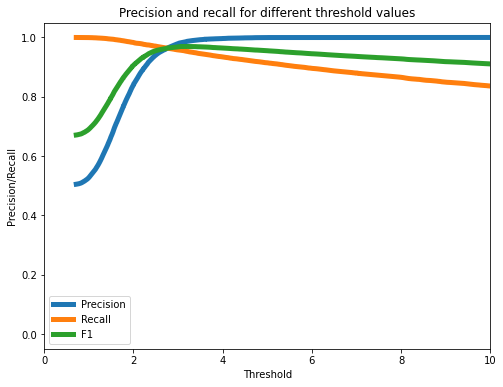

In [25]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['Weighted MSE'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0,10)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

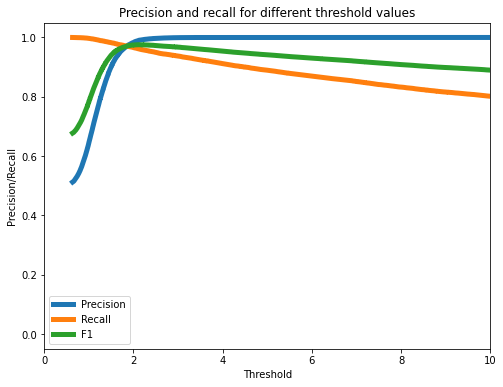

In [26]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['MSE'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0,10)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

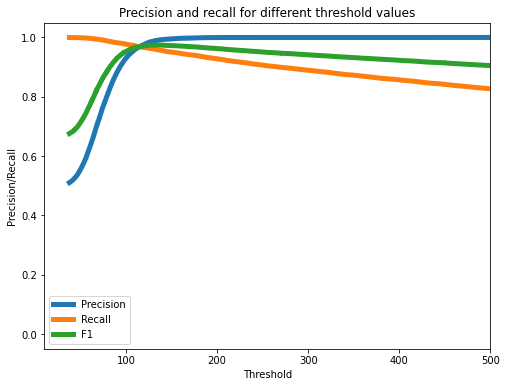

In [27]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['Chi2'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(10,500)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

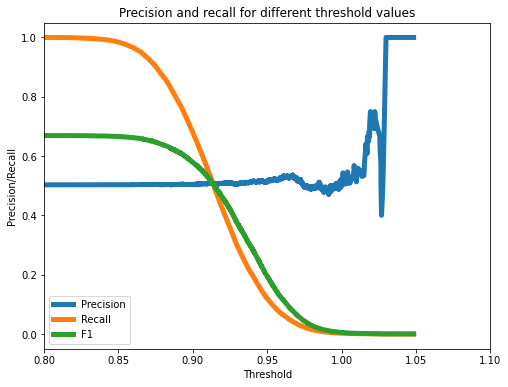

In [28]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['AVGSTD'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0.8,1.10)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

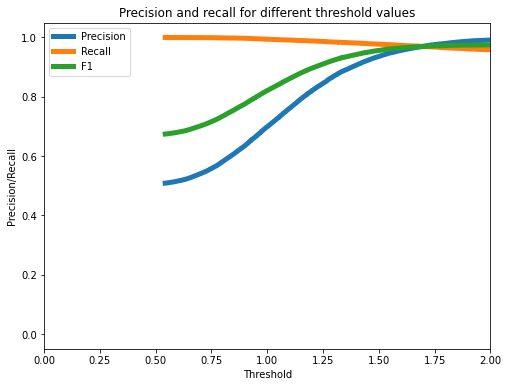

In [33]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['anomaly'])
F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
plt.xlim(0,2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

choose a threshold by eye looking at the scores

In [35]:
threshold_fixed = 1.65
pred_y = [0 if e < threshold_fixed else 1 for e in error_df['anomaly'].values]

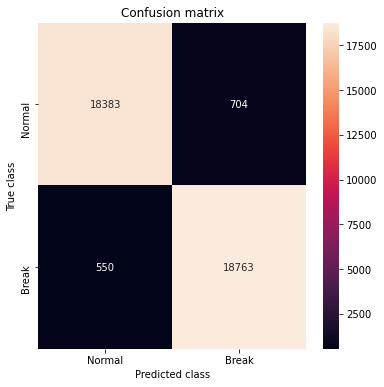

In [36]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

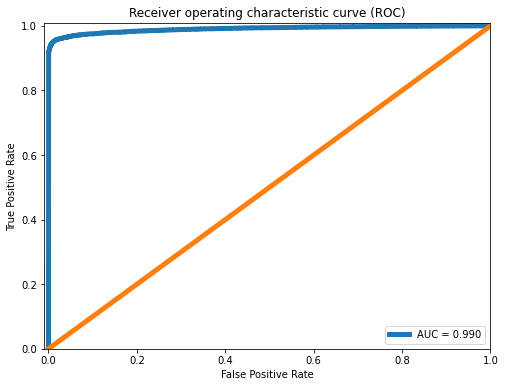

In [32]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df['Weighted MSE'])
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Do this for all different faults?

Or train another LSTM on top that does the classification

In [ ]:
def evaluate_performance(X_valid_scaled, fault, n_vals=10):
    X = X_valid_scaled[(y_valid==0)|(y_valid==fault)]   
    yhats = [lstm_autoencoder.predict(X) for _ in range(n_vals)]
    #average over all predictions 
    avg = np.squeeze(yhats).mean(axis=0)
    std = np.squeeze(yhats).std(axis=0)

    mse = np.mean(np.power(flatten(X)-flatten(avg),2),axis=1)
    print(mse)
    chi2 = np.sum(np.power(flatten(X)-flatten(avg),2)/flatten(std), axis=1)
    print(chi2)
    wmse = np.mean(np.power((flatten(X)-flatten(avg))/flatten(std),2),axis=1)
    print(len(wmse))
    y = np.zeros_like(y_valid)
    y[y_valid==fault] = 1
    print(len(y))
    error_df = pd.DataFrame({'MSE': mse,
                             'Weighted MSE': wmse,
                             'Chi2': chi2,
                              'True_class': y.tolist()})
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df['Weighted MSE'])
    F1 = 2* precision_rt*recall_rt/(precision_rt+recall_rt)
    plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
    plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
    plt.plot(threshold_rt, F1[1:], label="F1",linewidth=5)
    plt.xlim(0.5,10)
    plt.title('Precision and recall for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    plt.show()
    
    false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df['Weighted MSE'])
    roc_auc = auc(false_pos_rate, true_pos_rate,)

    plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1], linewidth=5)

    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='lower right')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
evaluate_performance(X_valid_scaled, 1, n_vals=10)

In [ ]:
[evaluate_performance(X_valid_scaled, i, n_vals=10) for i in np.unique(y_valid)]